In [1]:
# Ignorar Avisos
import warnings
warnings.filterwarnings('ignore')

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, make_scorer
from yellowbrick.model_selection import FeatureImportances
from math import pi
import pickle

# Carga dos Dados

In [3]:
df = pd.read_csv('DadosChurn.csv')

In [4]:
# Visualização dos dados sem concatenação
with pd.option_context('display.max_columns', None, 'display.width', None):
    display(df.head())

,ID_cliente,churn,genero,idoso,possui_parceiro,possui_dependentes,servico_telefonico,multiplas_linhas,servico_internet,DSL,fibra_otica,segurança_online,backup_online,protecao_do_dispositivo,suporte_tecnico,TV_cabo,streaming_filmes,fatura_online,tipo_contrato,tempo_contrato,metodo_pagamento,contas_diarias,conta_mensal,total_gasto,Mensal,Anual,Bienal,total_servicos
0,0002-ORFBO,False,Feminino,False,True,True,True,False,True,True,False,False,True,False,True,True,False,True,Anual,9,Cheque p/ Correio,2.19,65.6,593.30,False,True,False,5
1,0003-MKNFE,False,Masculino,False,False,False,True,True,True,True,False,False,False,False,False,False,True,False,Mensal,9,Cheque p/ Correio,2.00,59.9,542.40,True,False,False,4
2,0004-TLHLJ,True,Masculino,False,False,False,True,False,True,False,True,False,False,True,False,False,False,True,Mensal,4,Cheque Eletronico,2.46,73.9,280.85,True,False,False,3
3,0011-IGKFF,True,Masculino,True,True,False,True,False,True,False,True,False,True,True,False,True,True,True,Mensal,13,Cheque Eletronico,3.27,98.0,1237.85,True,False,False,6
4,0013-EXCHZ,True,Feminino,True,True,False,True,False,True,False,True,False,False,False,True,True,False,True,Mensal,3,Cheque p/ Correio,2.80,83.9,267.40,True,False,False,4


#

# Analise e Preparação do Dados

In [5]:
# Remoção da coluna ID_cliente e tipo contrato
df = df.drop(columns = 'ID_cliente')
df = df.drop(columns = 'tipo_contrato')

In [6]:
df.head()

,churn,genero,idoso,possui_parceiro,possui_dependentes,servico_telefonico,multiplas_linhas,servico_internet,DSL,fibra_otica,...,fatura_online,tempo_contrato,metodo_pagamento,contas_diarias,conta_mensal,total_gasto,Mensal,Anual,Bienal,total_servicos
0,False,Feminino,False,True,True,True,False,True,True,False,...,True,9,Cheque p/ Correio,2.19,65.6,593.30,False,True,False,5
1,False,Masculino,False,False,False,True,True,True,True,False,...,False,9,Cheque p/ Correio,2.00,59.9,542.40,True,False,False,4
2,True,Masculino,False,False,False,True,False,True,False,True,...,True,4,Cheque Eletronico,2.46,73.9,280.85,True,False,False,3
3,True,Masculino,True,True,False,True,False,True,False,True,...,True,13,Cheque Eletronico,3.27,98.0,1237.85,True,False,False,6
4,True,Feminino,True,True,False,True,False,True,False,True,...,True,3,Cheque p/ Correio,2.80,83.9,267.40,True,False,False,4


In [7]:
# Alterando valores booleanos para 0 e 1
for col in df.columns:
    df[col].replace({False: 0, True: 1}, inplace = True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   churn                    7043 non-null   int64  
 1   genero                   7043 non-null   object 
 2   idoso                    7043 non-null   int64  
 3   possui_parceiro          7043 non-null   int64  
 4   possui_dependentes       7043 non-null   int64  
 5   servico_telefonico       7043 non-null   int64  
 6   multiplas_linhas         7043 non-null   int64  
 7   servico_internet         7043 non-null   int64  
 8   DSL                      7043 non-null   int64  
 9   fibra_otica              7043 non-null   int64  
 10  segurança_online         7043 non-null   int64  
 11  backup_online            7043 non-null   int64  
 12  protecao_do_dispositivo  7043 non-null   int64  
 13  suporte_tecnico          7043 non-null   int64  
 14  TV_cabo                 

In [9]:
var_catego = ['genero','metodo_pagamento']
for col in var_catego:
    print(df[col].value_counts())
    print(30 * '-', '\n')

genero
Masculino    3555
Feminino     3488
Name: count, dtype: int64
------------------------------ 

metodo_pagamento
Cheque Eletronico                2365
Cheque p/ Correio                1612
Transferencia Bancaria (AUTO)    1544
Cartão de Credito (AUTO)         1522
Name: count, dtype: int64
------------------------------ 



In [10]:
# Aplicando One Hot Encoding nas variaveis categoricas restantes
df = pd.get_dummies(data = df, columns = var_catego, dtype = int)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 30 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   churn                                           7043 non-null   int64  
 1   idoso                                           7043 non-null   int64  
 2   possui_parceiro                                 7043 non-null   int64  
 3   possui_dependentes                              7043 non-null   int64  
 4   servico_telefonico                              7043 non-null   int64  
 5   multiplas_linhas                                7043 non-null   int64  
 6   servico_internet                                7043 non-null   int64  
 7   DSL                                             7043 non-null   int64  
 8   fibra_otica                                     7043 non-null   int64  
 9   segurança_online                         

In [12]:
with pd.option_context('display.max_columns', None, 'display.width', None):
    display(df.head())

,churn,idoso,possui_parceiro,possui_dependentes,servico_telefonico,multiplas_linhas,servico_internet,DSL,fibra_otica,segurança_online,backup_online,protecao_do_dispositivo,suporte_tecnico,TV_cabo,streaming_filmes,fatura_online,tempo_contrato,contas_diarias,conta_mensal,total_gasto,Mensal,Anual,Bienal,total_servicos,genero_Feminino,genero_Masculino,metodo_pagamento_Cartão de Credito (AUTO),metodo_pagamento_Cheque Eletronico,metodo_pagamento_Cheque p/ Correio,metodo_pagamento_Transferencia Bancaria (AUTO)
0,0,0,1,1,1,0,1,1,0,0,1,0,1,1,0,1,9,2.19,65.6,593.30,0,1,0,5,1,0,0,0,1,0
1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,0,9,2.00,59.9,542.40,1,0,0,4,0,1,0,0,1,0
2,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,4,2.46,73.9,280.85,1,0,0,3,0,1,0,1,0,0
3,1,1,1,0,1,0,1,0,1,0,1,1,0,1,1,1,13,3.27,98.0,1237.85,1,0,0,6,0,1,0,1,0,0
4,1,1,1,0,1,0,1,0,1,0,0,0,1,1,0,1,3,2.80,83.9,267.40,1,0,0,4,1,0,0,0,1,0


In [13]:
list(df.columns)

['churn',
 'idoso',
 'possui_parceiro',
 'possui_dependentes',
 'servico_telefonico',
 'multiplas_linhas',
 'servico_internet',
 'DSL',
 'fibra_otica',
 'segurança_online',
 'backup_online',
 'protecao_do_dispositivo',
 'suporte_tecnico',
 'TV_cabo',
 'streaming_filmes',
 'fatura_online',
 'tempo_contrato',
 'contas_diarias',
 'conta_mensal',
 'total_gasto',
 'Mensal',
 'Anual',
 'Bienal',
 'total_servicos',
 'genero_Feminino',
 'genero_Masculino',
 'metodo_pagamento_Cartão de Credito (AUTO)',
 'metodo_pagamento_Cheque Eletronico',
 'metodo_pagamento_Cheque p/ Correio',
 'metodo_pagamento_Transferencia Bancaria (AUTO)']

In [14]:
# Adicionando coluna para o total de serviços contratados por cliente
df['total_servicos_contratados'] = df[[
    'servico_telefonico',
    'servico_internet',
    'TV_cabo',
    'segurança_online',
    'backup_online',
    'protecao_do_dispositivo',
    'multiplas_linhas',
    'suporte_tecnico',
    'streaming_filmes'    
]].sum(axis = 1)

In [15]:
df.head()

,churn,idoso,possui_parceiro,possui_dependentes,servico_telefonico,multiplas_linhas,servico_internet,DSL,fibra_otica,segurança_online,...,Anual,Bienal,total_servicos,genero_Feminino,genero_Masculino,metodo_pagamento_Cartão de Credito (AUTO),metodo_pagamento_Cheque Eletronico,metodo_pagamento_Cheque p/ Correio,metodo_pagamento_Transferencia Bancaria (AUTO),total_servicos_contratados
0,0,0,1,1,1,0,1,1,0,0,...,1,0,5,1,0,0,0,1,0,5
1,0,0,0,0,1,1,1,1,0,0,...,0,0,4,0,1,0,0,1,0,4
2,1,0,0,0,1,0,1,0,1,0,...,0,0,3,0,1,0,1,0,0,3
3,1,1,1,0,1,0,1,0,1,0,...,0,0,6,0,1,0,1,0,0,6
4,1,1,1,0,1,0,1,0,1,0,...,0,0,4,1,0,0,0,1,0,4


In [16]:
df[['genero_Feminino', 'genero_Masculino']].corr()

,genero_Feminino,genero_Masculino
genero_Feminino,1.0,-1.0
genero_Masculino,-1.0,1.0


In [17]:
df[['contas_diarias', 'conta_mensal']].corr()

,contas_diarias,conta_mensal
contas_diarias,1.000000,0.999996
conta_mensal,0.999996,1.000000


In [18]:
df[['servico_internet', 'DSL', 'fibra_otica']].corr()

,servico_internet,DSL,fibra_otica
servico_internet,1.000000,0.380635,0.465793
DSL,0.380635,1.000000,-0.640987
fibra_otica,0.465793,-0.640987,1.000000


In [19]:
# Devido a alta correlação entre as variaveis: ['genero_Feminino', 'genero_Masculino'] sera excuido a coluna genero_Masculino
# Devido a alta correlação entre as variaveis: ['contas_diarias', 'conta_mensal'] sera excuido a coluna contas_diarias
df.drop(columns = ['genero_Masculino', 'contas_diarias'] , inplace = True)

In [20]:
df.head(2)

,churn,idoso,possui_parceiro,possui_dependentes,servico_telefonico,multiplas_linhas,servico_internet,DSL,fibra_otica,segurança_online,...,Mensal,Anual,Bienal,total_servicos,genero_Feminino,metodo_pagamento_Cartão de Credito (AUTO),metodo_pagamento_Cheque Eletronico,metodo_pagamento_Cheque p/ Correio,metodo_pagamento_Transferencia Bancaria (AUTO),total_servicos_contratados
0,0,0,1,1,1,0,1,1,0,0,...,0,1,0,5,1,0,0,1,0,5
1,0,0,0,0,1,1,1,1,0,0,...,1,0,0,4,0,0,0,1,0,4


In [21]:
print("\nDistribuição de Churn (0=Não, 1=Sim):")
print(df['churn'].value_counts(normalize=True) * 100)


Distribuição de Churn (0=Não, 1=Sim):
churn
0    73.463013
1    26.536987
Name: proportion, dtype: float64


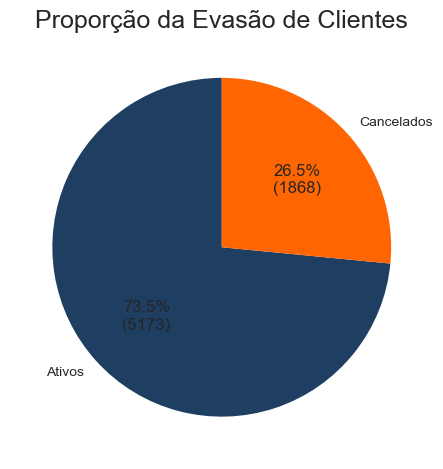

In [22]:
plt.title('Proporção da Evasão de Clientes', fontsize = 18)

plt.pie(
    df['churn'].value_counts(),
    labels = df['churn'].value_counts().index.map({0: 'Ativos', 1: 'Cancelados'}),
    autopct = lambda pct: f'{pct:.1f}%\n({int(pct/100*sum(df['churn'].value_counts()))})',
    startangle = 90,
    colors=['#1E3E62','#FF6500']
);

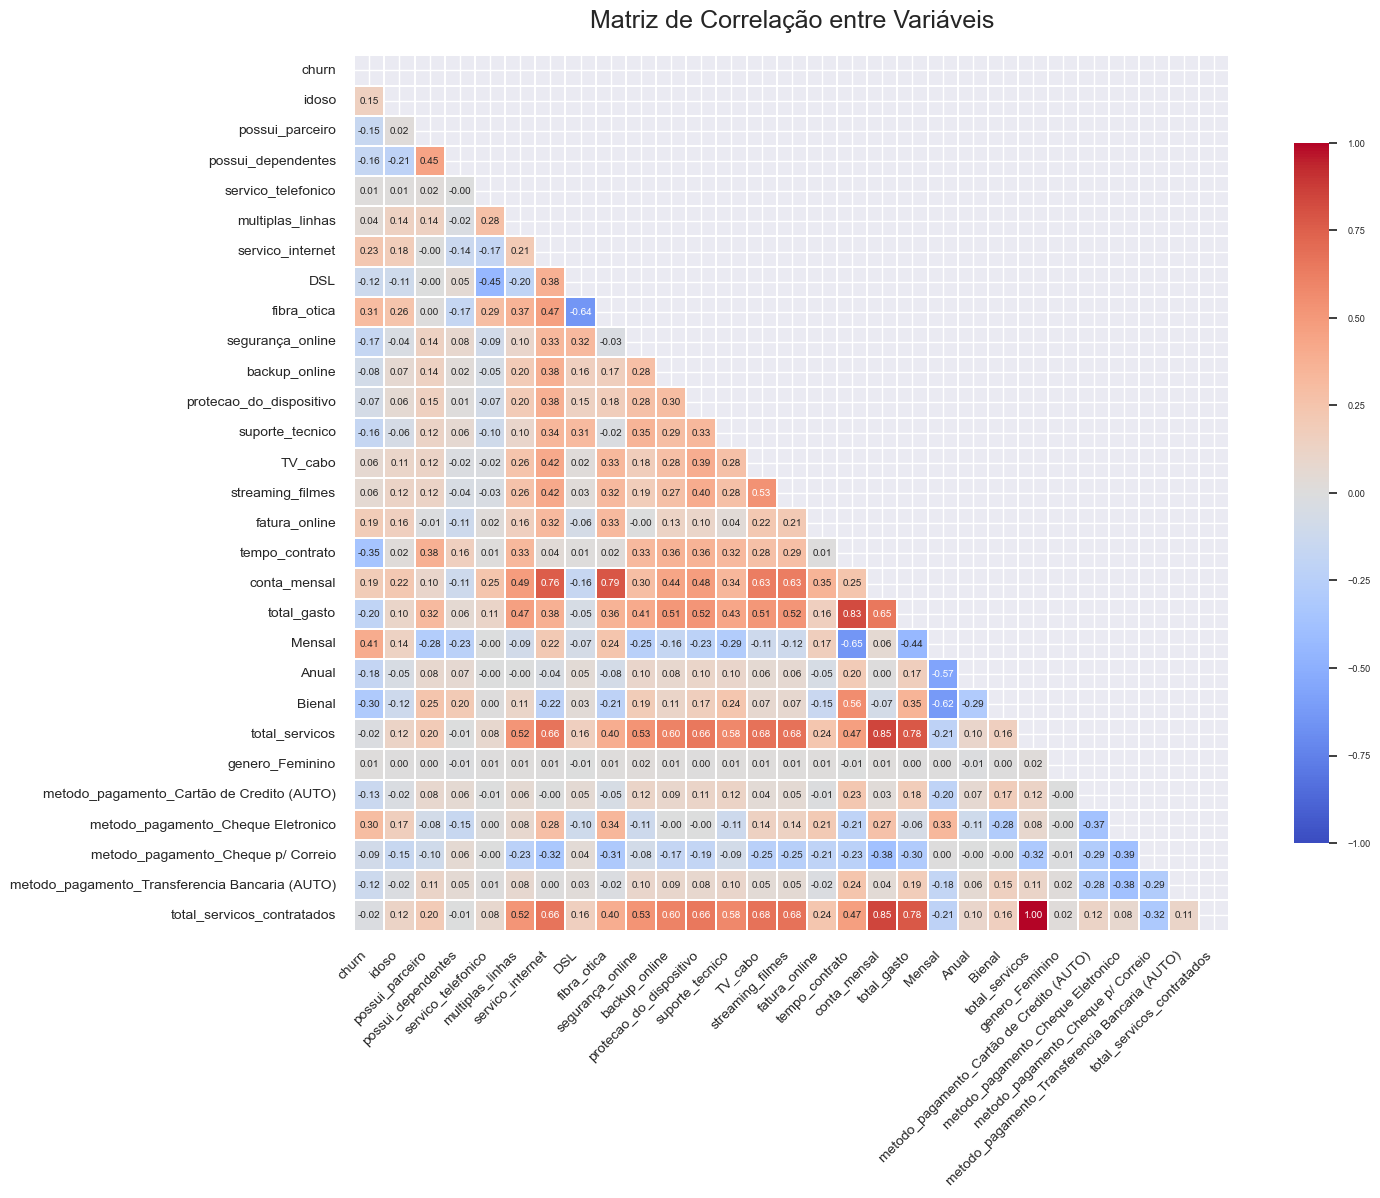

In [23]:
plt.figure(figsize=(16, 12)) 
sns.set(font_scale=0.6)

corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

heatmap = sns.heatmap(
    corr,
    mask = mask,
    annot = True,
    fmt = '.2f',
    cmap = 'coolwarm',
    center = 0,
    vmin = -1,
    vmax = 1,
    linewidths = 0.2,
    square = True,
    cbar_kws={'shrink': 0.8}
)

plt.title('Matriz de Correlação entre Variáveis', pad = 20, fontsize = 18)
plt.xticks(rotation = 45, ha = 'right', fontsize = 10)
plt.yticks(rotation = 0, fontsize = 10)

plt.tight_layout()
plt.show()

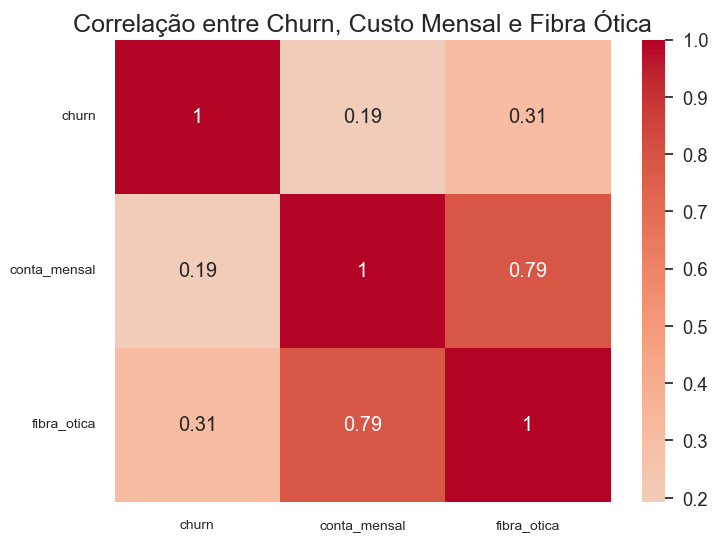

In [111]:
corr_selecao = df[['churn', 'conta_mensal', 'fibra_otica']].corr()

plt.figure(figsize = (8, 6))
sns.heatmap(corr_selecao, annot = True, cmap = 'coolwarm', center = 0)
plt.title('Correlação entre Churn, Custo Mensal e Fibra Ótica', fontsize = 18)
plt.xticks(fontsize = 10)
plt.yticks(rotation = 0, fontsize = 10)
plt.savefig('Custo_Fibra.jpg', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close();

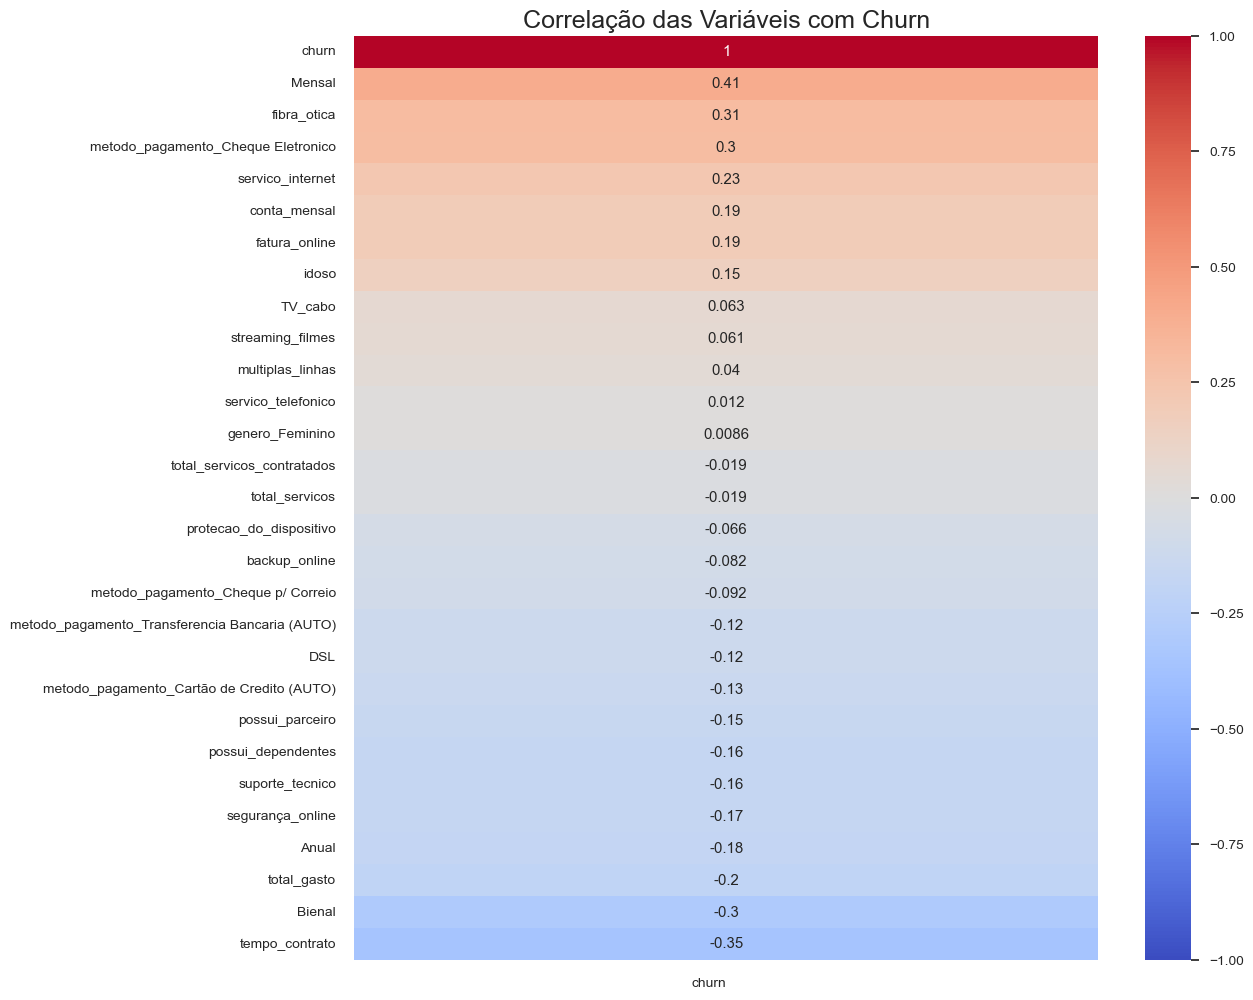

In [25]:
plt.figure(figsize = (12, 12))
sns.set(font_scale=0.9)

corr = df.corr()[['churn']].sort_values(by = 'churn', ascending = False)

sns.heatmap(corr, annot=True, cmap='coolwarm', vmin = -1, vmax = 1)
plt.title('Correlação das Variáveis com Churn', fontsize = 18)
plt.xticks(ha = 'right', fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

# 

# Modelagem Preditiva

In [26]:
# Função para gerar grafico de matriz de confusão
def matriz_confusao(modelo, valores, previsao):
    matriz_confusao = confusion_matrix(valores, previsao)
    visualizacao = ConfusionMatrixDisplay(confusion_matrix = matriz_confusao, display_labels = ['Ativo', 'Cancelado'])
    
    fig, ax = plt.subplots(figsize = (10, 6))
    visualizacao.plot(ax = ax, cmap='viridis')
    ax.grid(False)
    plt.title(f'Matriz de Confusão: {modelo}', fontsize = 16)
    plt.xlabel('Valor Previsto\n')
    plt.ylabel('\nValor Real')

    plt.show()

In [27]:
# Divisão das features e variavel alvo
X = df.drop(columns = 'churn')
y = df.churn

In [28]:
# Divisão entre variavel de treinamento, variavel de validação e 10% para variavel de teste
X, X_teste, y, y_teste = train_test_split(X, y, test_size = 0.10, stratify = y, random_state = 10)
X_treino, X_val, y_treino, y_val = train_test_split(X, y, stratify = y, random_state = 10)

### Criação do modelo dummy para base de comparação

In [29]:
modelo_dummy = DummyClassifier(strategy="stratified", random_state = 10)
modelo_dummy.fit(X_treino, y_treino)
pred_modelo_dummy = modelo_dummy.predict(X_val)
print(classification_report(y_val, pred_modelo_dummy))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1164
           1       0.28      0.29      0.28       421

    accuracy                           0.62      1585
   macro avg       0.51      0.51      0.51      1585
weighted avg       0.62      0.62      0.62      1585



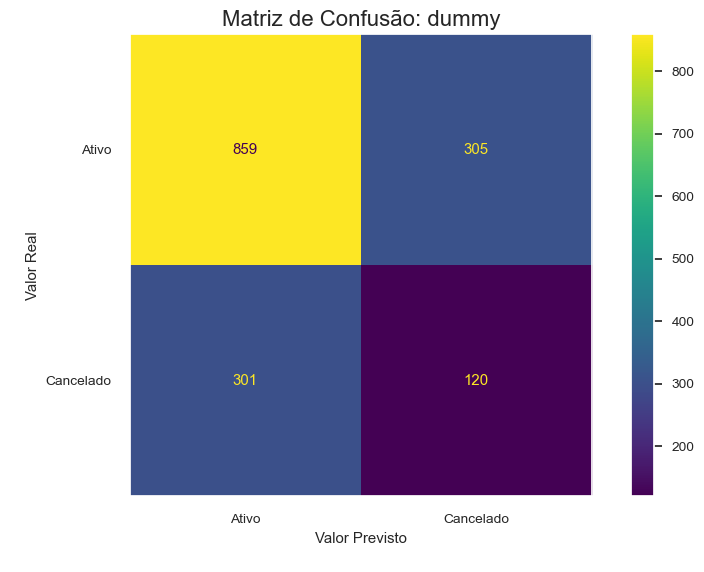

In [30]:
matriz_confusao('dummy', y_val, pred_modelo_dummy)

### Modelos com RandomForestClassifier()

##### - Modelo 0

Acurácia: 0.777
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1164
           1       0.59      0.51      0.55       421

    accuracy                           0.78      1585
   macro avg       0.71      0.69      0.70      1585
weighted avg       0.77      0.78      0.77      1585



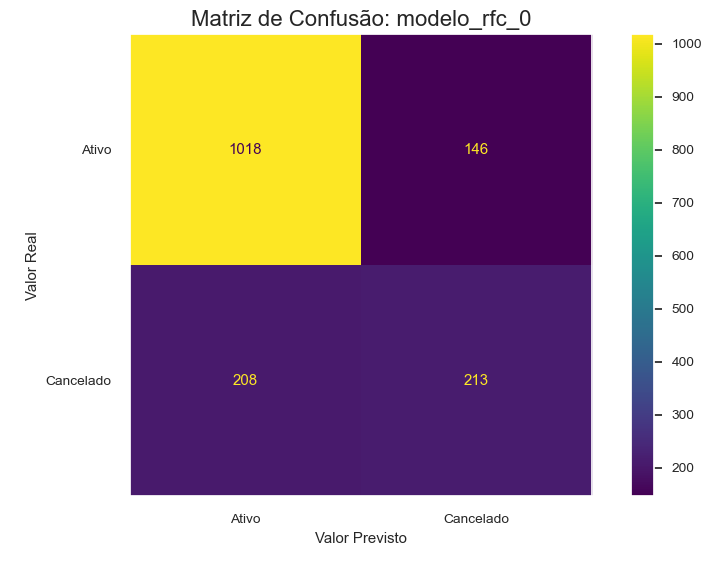

In [31]:
modelo_rfc_0 = RandomForestClassifier(random_state = 10)
modelo_rfc_0.fit(X_treino, y_treino)
pred_modelo_rfc_0 = modelo_rfc_0.predict(X_val)
print(f'Acurácia: {modelo_rfc_0.score(X_val, y_val):.3f}')
print(classification_report(y_val, pred_modelo_rfc_0))
matriz_confusao('modelo_rfc_0', y_val, pred_modelo_rfc_0)

##### - Modelo 1: Adicionando profundidade maxima das arvores

Acurácia: 0.801
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1164
           1       0.65      0.54      0.59       421

    accuracy                           0.80      1585
   macro avg       0.75      0.72      0.73      1585
weighted avg       0.79      0.80      0.79      1585



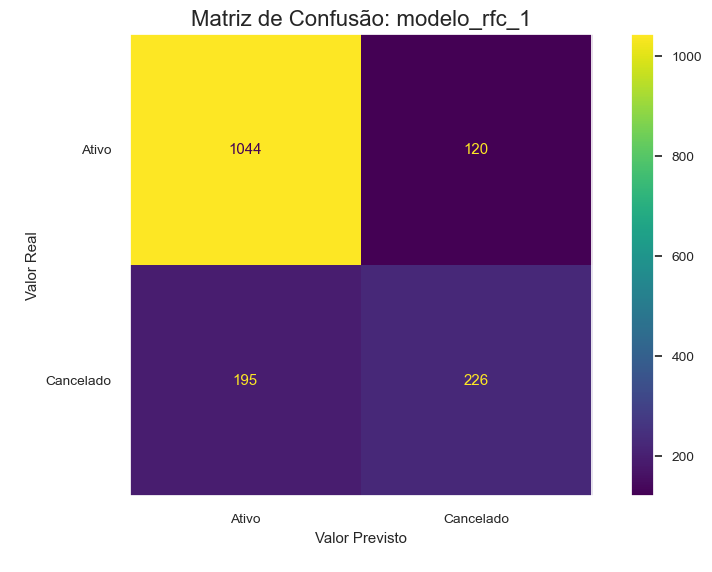

In [32]:
modelo_rfc_1 = RandomForestClassifier(max_depth = 10)
modelo_rfc_1.fit(X_treino, y_treino)
pred_modelo_rfc_1 = modelo_rfc_1.predict(X_val)
print(f'Acurácia: {modelo_rfc_1.score(X_val, y_val):.3f}')
print(classification_report(y_val, pred_modelo_rfc_1))
matriz_confusao('modelo_rfc_1', y_val, pred_modelo_rfc_1)

##### - Modelo 2: Balanceando as classes 

Acurácia: 0.765
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1164
           1       0.54      0.72      0.62       421

    accuracy                           0.76      1585
   macro avg       0.71      0.75      0.72      1585
weighted avg       0.79      0.76      0.77      1585



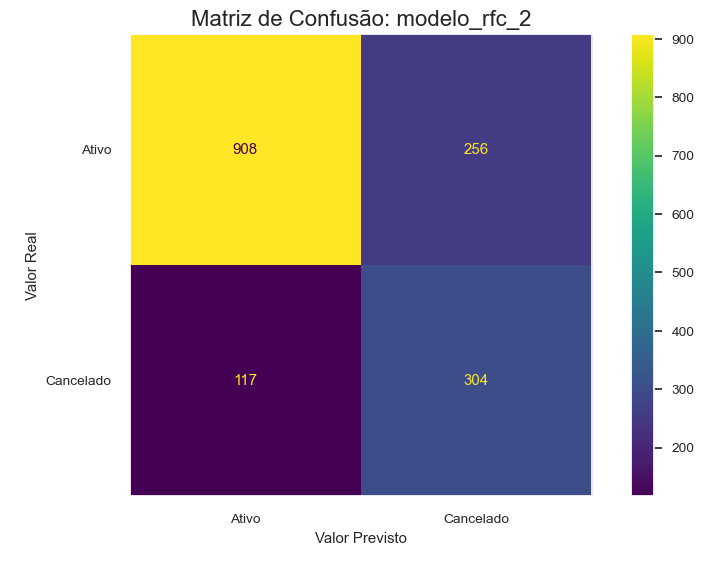

In [33]:
pesos_classes = {0: 1, 1: 3}  
modelo_rfc_2 = RandomForestClassifier(class_weight = pesos_classes, max_depth = 10, random_state = 10)
modelo_rfc_2.fit(X_treino, y_treino)
pred_modelo_rfc_2 = modelo_rfc_2.predict(X_val)
print(f'Acurácia: {modelo_rfc_2.score(X_val, y_val):.3f}')
print(classification_report(y_val, pred_modelo_rfc_2))
matriz_confusao('modelo_rfc_2', y_val, pred_modelo_rfc_2)

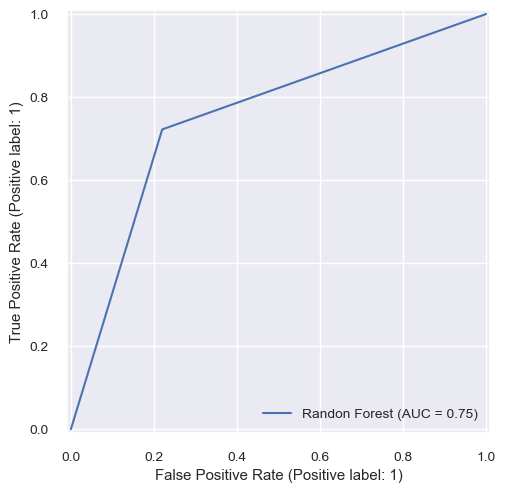

In [34]:
RocCurveDisplay.from_predictions(y_val, pred_modelo_rfc_2, name = 'Randon Forest');

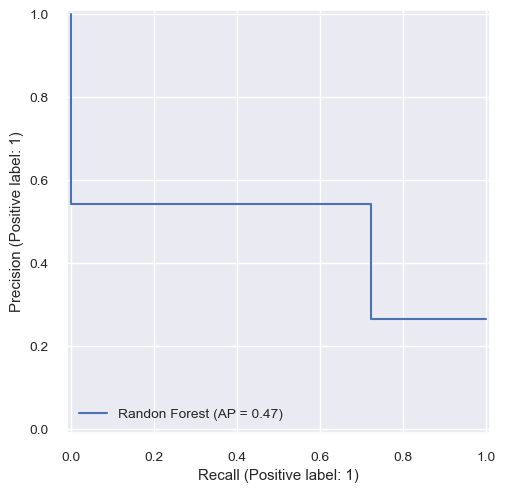

In [35]:
PrecisionRecallDisplay.from_predictions(y_val, pred_modelo_rfc_2, name = 'Randon Forest');

In [93]:
# Realizando validação cruzada
kf = KFold(n_splits = 5, shuffle = True, random_state = 5)
cv_resultados = cross_validate(modelo_rfc_2, X, y, cv = kf)
media = cv_resultados['test_score'].mean()
desvio_padrao = cv_resultados['test_score'].std()
print(f'Intervalo de confiança: [{media - (1.5 * desvio_padrao):.3f}, {min(media + (1.5 *desvio_padrao),1):.3f}]')

Intervalo de confiança: [0.761, 0.786]


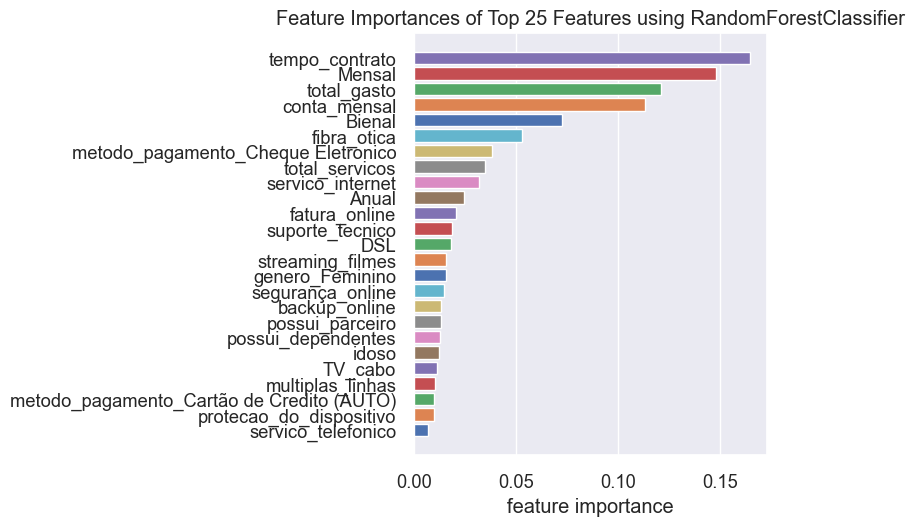

In [94]:
# Verificação das variaveis mais relevantes
viz = FeatureImportances(modelo_rfc_2, relative = False, topn = 28)
viz.fit(X_treino, y_treino)
viz.show();

In [38]:
importances = modelo_rfc_2.feature_importances_

feature_importances = pd.DataFrame({'Features': X.columns, 'Importances': importances})
feature_importances.sort_values('Importances', ascending=False)

,Features,Importances
18,Mensal,0.156350
15,tempo_contrato,0.136748
17,total_gasto,0.117309
16,conta_mensal,0.108333
20,Bienal,0.081159
7,fibra_otica,0.053092
24,metodo_pagamento_Cheque Eletronico,0.033038
5,servico_internet,0.029035
19,Anual,0.027625
21,total_servicos,0.026405


In [105]:
# Teste para identificar o impacto das variaveis no modelo
results_df = pd.DataFrame(index=['Acurácia', 'Precisão', 'Recall', 'F1-Score', 'AUC-ROC'])

for count in [1, 5, 10, 15, 20, 25, 29]:
    features_selecionadas = feature_importances['Features'].values[:count]

    X_treino_selecionado = X_treino[features_selecionadas]
    X_val_selecionado = X_val[features_selecionadas]

    modelo_rfc_2.fit(X_treino_selecionado, y_treino)

    y_proba = modelo_rfc_2.predict_proba(X_val_selecionado)[:, 1]
    y_pred = modelo_rfc_2.predict(X_val_selecionado)

    metrics = {
        'Acurácia': accuracy_score(y_val, y_pred),
        'Precisão': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'F1-Score': f1_score(y_val, y_pred),
        'AUC-ROC': roc_auc_score(y_val, y_proba)
    }

    results_df[count] = list(metrics.values())


results_df   


,1,5,10,15,20,25,29
Acurácia,0.717350,0.562776,0.678233,0.719874,0.760252,0.767192,0.764669
Precisão,0.447059,0.348214,0.438790,0.479930,0.536542,0.547619,0.542857
Recall,0.270784,0.741093,0.757720,0.653207,0.714964,0.710214,0.722090
F1-Score,0.337278,0.473804,0.555749,0.553320,0.613035,0.618407,0.619776
AUC-ROC,0.574825,0.670819,0.761305,0.756030,0.827398,0.830933,0.832681


In [101]:
results_df = pd.DataFrame(index=['Acurácia', 'Precisão', 'Recall', 'F1-Score', 'AUC-ROC'])

for count in range(15, 26):
    features_selecionadas = feature_importances['Features'].values[:count]

    X_treino_selecionado = X_treino[features_selecionadas]
    X_val_selecionado = X_val[features_selecionadas]

    modelo_rfc_2.fit(X_treino_selecionado, y_treino)

    y_proba = modelo_rfc_2.predict_proba(X_val_selecionado)[:, 1]
    y_pred = modelo_rfc_2.predict(X_val_selecionado)

    metrics = {
        'Acurácia': accuracy_score(y_val, y_pred),
        'Precisão': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'F1-Score': f1_score(y_val, y_pred),
        'AUC-ROC': roc_auc_score(y_val, y_proba)
    }

    results_df[count] = list(metrics.values())



results_df   

,15,16,17,18,19,20,21,22,23,24,25
Acurácia,0.719874,0.748896,0.756467,0.754574,0.765931,0.760252,0.758360,0.758360,0.755836,0.763407,0.767192
Precisão,0.479930,0.520426,0.532468,0.529630,0.545788,0.536542,0.533451,0.532872,0.529110,0.540351,0.547619
Recall,0.653207,0.695962,0.681710,0.679335,0.707838,0.714964,0.719715,0.731591,0.733967,0.731591,0.710214
F1-Score,0.553320,0.595528,0.597917,0.595213,0.616339,0.613035,0.612740,0.616617,0.614925,0.621594,0.618407
AUC-ROC,0.756030,0.817186,0.818056,0.824407,0.829135,0.827398,0.828679,0.826224,0.831030,0.832768,0.830933


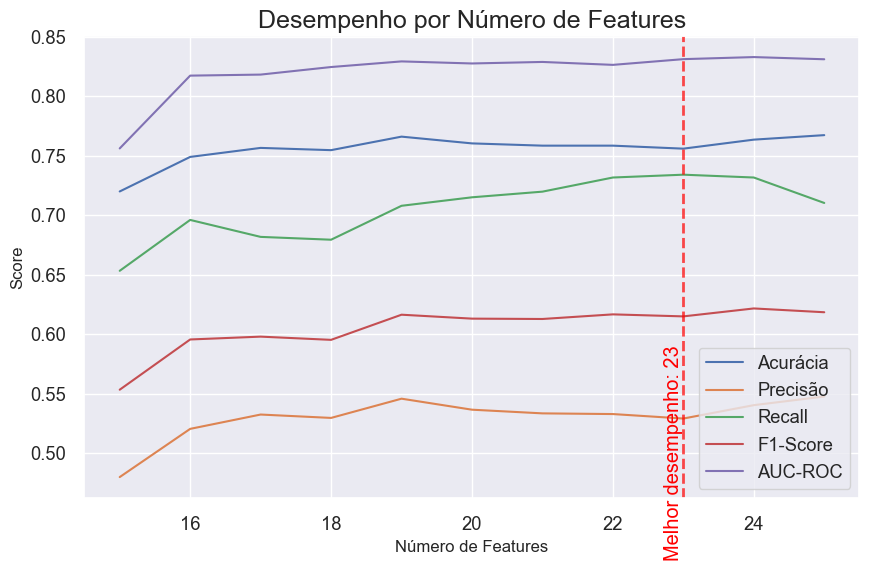

In [102]:
results_df.T.plot(figsize=(10, 6)) 
plt.title('Desempenho por Número de Features', fontsize = 18)
plt.xlabel('Número de Features', fontsize = 12)
plt.ylabel('Score', fontsize = 12)
plt.axvline(x = 23, color = 'red', linestyle = '--', alpha = 0.7, linewidth = 2)
plt.legend(loc = 'lower right', frameon = True )
plt.text(x=23, y=0.5, s='Melhor desempenho: 23', rotation=90, 
         color='red', va='center', ha='right')
plt.grid(True)

plt.savefig('23_features.jpg', dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close()

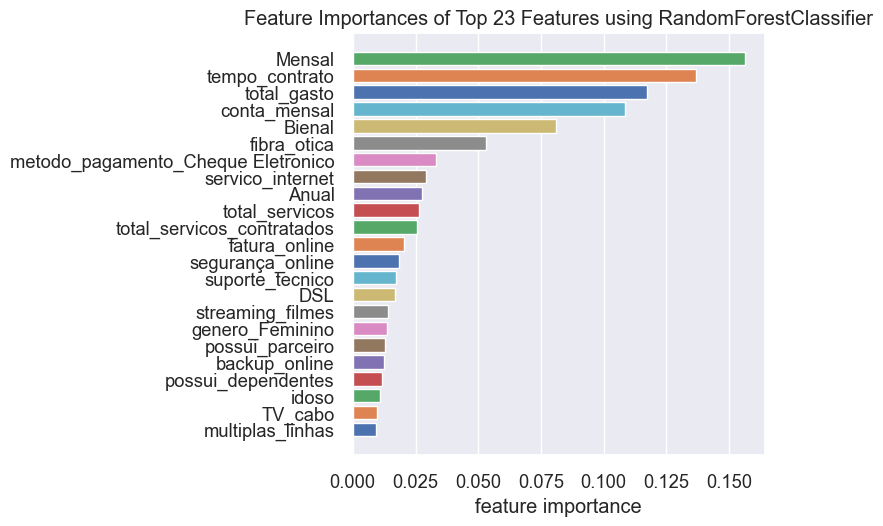

In [108]:
viz = FeatureImportances(modelo_rfc_2, relative = False, topn = 23)
viz.fit(X_treino, y_treino)
plt.savefig('Grafico_23_features', dpi = 300, bbox_inches='tight')
viz.show()
plt.close()

In [42]:
features_selecionadas = feature_importances['Features'].values[:23]
X_features_selecionadas = X[features_selecionadas]
X_features_selecionadas

,idoso,possui_parceiro,possui_dependentes,servico_telefonico,multiplas_linhas,servico_internet,DSL,fibra_otica,segurança_online,backup_online,...,streaming_filmes,fatura_online,tempo_contrato,conta_mensal,total_gasto,Mensal,Anual,Bienal,total_servicos,genero_Feminino
1401,0,1,0,0,0,1,1,0,0,1,...,0,0,41,35.45,1391.65,0,1,0,3,1
5025,1,0,0,1,1,1,0,1,0,1,...,1,1,48,99.00,4744.35,0,1,0,6,0
4177,0,1,1,1,0,1,1,0,0,1,...,0,1,45,54.15,2319.80,0,1,0,4,1
1062,0,1,0,1,0,1,0,1,0,1,...,1,0,32,84.15,2585.95,1,0,0,4,1
3782,0,1,1,1,1,1,1,0,1,0,...,0,0,58,75.80,4415.75,0,0,1,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3687,0,1,1,1,1,1,0,1,1,1,...,0,1,42,94.45,3923.80,0,1,0,6,1
3825,0,1,1,1,1,1,1,0,1,1,...,1,0,71,91.05,6293.75,0,0,1,9,1
6304,0,1,1,1,0,0,0,0,0,0,...,0,0,60,19.65,1161.75,0,0,1,1,0
6897,0,0,0,0,0,1,1,0,0,0,...,0,1,7,24.35,150.85,0,1,0,1,0


##### - Model_grid: Busca do melhor modelos com GridSearchCV e Features Selecionadas

In [43]:
# Separando novas variaveis de treinamento e validação com as features selecionadas
X_treino_sel, X_val_sel, y_treino_sel, y_val_sel = train_test_split(X_features_selecionadas, y, stratify = y, random_state = 10)

In [44]:
param_grid = {
    'class_weight' :['balanced', {0: 1, 1: 2}, {0: 1, 1: 3}],
    'max_depth' : [5, 10, 15],
    'min_samples_leaf' : [1, 2, 3],
    'min_samples_split' : [2, 4, 6],
    'n_estimators' : [100, 150, 200]
}

cv = KFold(n_splits = 5, shuffle = True, random_state = 10)

scoring = {
    'Recall': make_scorer(recall_score),
    'F1': make_scorer(f1_score),
    'AUC': make_scorer(roc_auc_score)
}
model_grid = GridSearchCV(
                RandomForestClassifier(random_state = 10),
                param_grid = param_grid, 
                scoring = scoring,
                refit = 'Recall',
                cv = cv,
                n_jobs = -1
            )
model_grid.fit(X_treino_sel,  y_treino_sel)

GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
             estimator=RandomForestClassifier(random_state=10), n_jobs=-1,
             param_grid={'class_weight': ['balanced', {0: 1, 1: 2},
                                          {0: 1, 1: 3}],
                         'max_depth': [5, 10, 15],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 150, 200]},
             refit='Recall',
             scoring={'AUC': make_scorer(roc_auc_score, response_method='predict'),
                      'F1': make_scorer(f1_score, response_method='predict'),
                      'Recall': make_scorer(recall_score, response_method='predict')})

In [45]:
print(f"Melhor Recall (validação): {model_grid.best_score_:.3f}")

Melhor Recall (validação): 0.826


Acurácia: 0.815
AUC-ROC: 0.834
              precision    recall  f1-score   support

           0       0.91      0.69      0.78      1164
           1       0.49      0.81      0.61       421

    accuracy                           0.72      1585
   macro avg       0.70      0.75      0.70      1585
weighted avg       0.80      0.72      0.74      1585



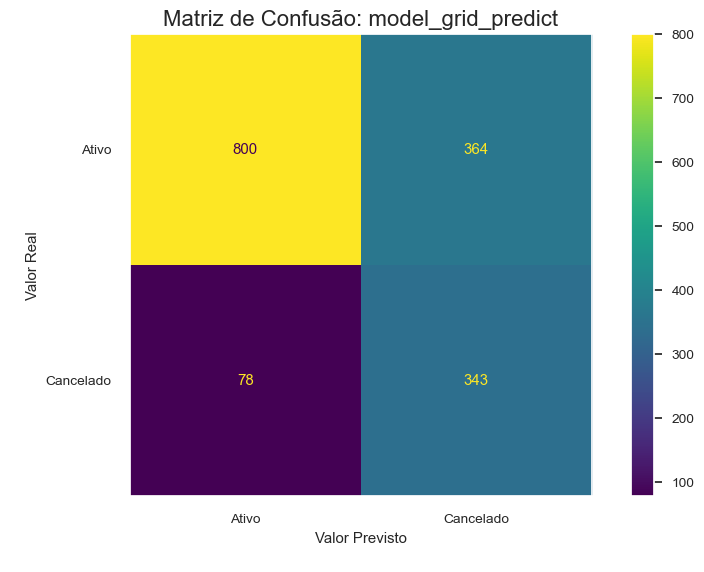

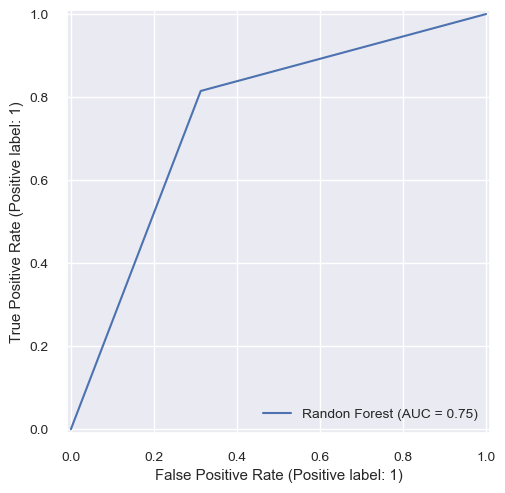

In [64]:
model_grid_predict = model_grid.predict(X_val_sel)
y_proba = model_grid.predict_proba(X_val_sel)[:, 1]
print(f'Acurácia: {model_grid.score(X_val_sel, y_val_sel):.3f}')
print(f'AUC-ROC: {roc_auc_score(y_val_sel, y_proba):.3f}', )
print(classification_report(y_val_sel, model_grid_predict))
matriz_confusao('model_grid_predict', y_val_sel, model_grid_predict)
RocCurveDisplay.from_predictions(y_val_sel, model_grid_predict, name = 'Randon Forest');

#### Testando model_grid com as variaveis de teste

Acurácia: 0.829
AUC-ROC: 0.856
              precision    recall  f1-score   support

           0       0.92      0.72      0.81       518
           1       0.51      0.83      0.64       187

    accuracy                           0.75       705
   macro avg       0.72      0.77      0.72       705
weighted avg       0.81      0.75      0.76       705



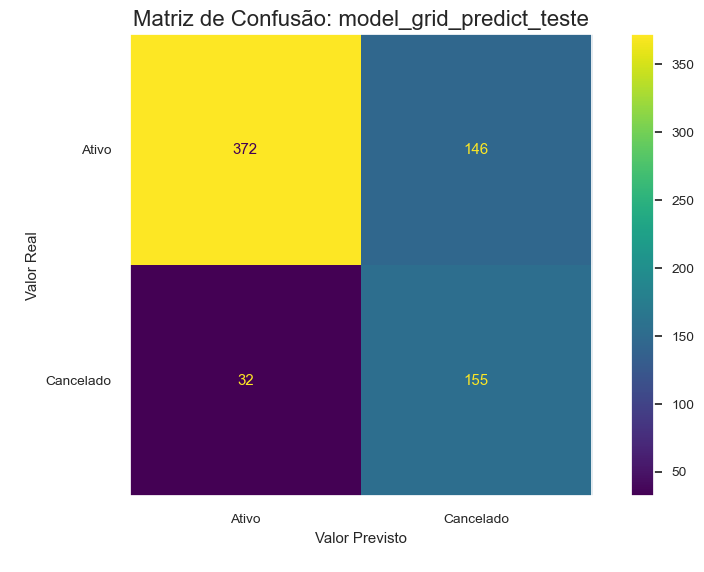

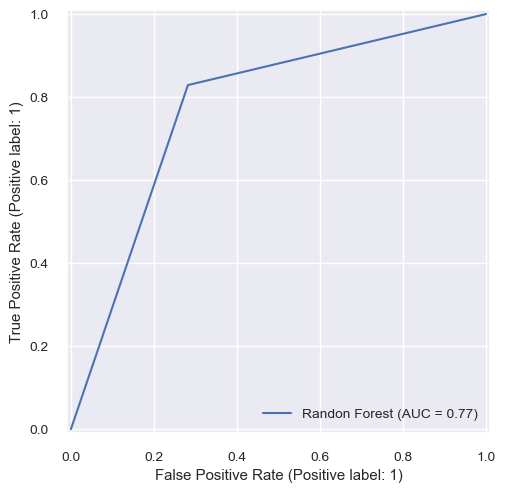

In [67]:
model_grid_predict_teste = model_grid.predict(X_teste[features_selecionadas])
y_proba = model_grid.predict_proba(X_teste[features_selecionadas])[:, 1]
print(f'Acurácia: {model_grid.score(X_teste[features_selecionadas], y_teste):.3f}')
print(f'AUC-ROC: {roc_auc_score(y_teste, y_proba):.3f}', )
print(classification_report(y_teste, model_grid_predict_teste))
matriz_confusao('model_grid_predict_teste', y_teste, model_grid_predict_teste)
RocCurveDisplay.from_predictions(y_teste, model_grid_predict_teste, name = 'Randon Forest');

### Modelo com XGBoost

In [50]:
# Verificação de quantas features usar
xgb_23 = XGBClassifier(scale_pos_weight = 3)  
scores_23 = cross_val_score(xgb_23, X_treino_sel, y_treino_sel, 
                          cv=5, scoring='recall')

xgb_all = XGBClassifier(scale_pos_weight = 3)
scores_all = cross_val_score(xgb_all, X_treino, y_treino,
                           cv=5, scoring='recall')

print(f"AUC-ROC (23 features): {scores_23.mean():.3f}")
print(f"AUC-ROC (todas features): {scores_all.mean():.3f}")

AUC-ROC (23 features): 0.670
AUC-ROC (todas features): 0.659


In [51]:
param_grid_xgb = {
    'scale_pos_weight': [1, 2, 3],  
    'max_depth': [5, 10, 15],
    'min_child_weight': [1, 2, 3],   
    'gamma': [0, 0.1, 0.2],          
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.05, 0.1],    
    'subsample': [0.8, 1.0]          
}

cv = KFold(n_splits = 5, shuffle = True, random_state = 10)

scoring = {
    'Recall': make_scorer(recall_score),
    'F1': make_scorer(f1_score),
    'AUC': make_scorer(roc_auc_score)
}

model_grid_xgb = GridSearchCV(
    XGBClassifier(random_state = 10, 
                 eval_metric = 'logloss',  
                 use_label_encoder = False),
    param_grid = param_grid_xgb,
    scoring = scoring,
    refit = 'Recall',  
    cv = cv,
    n_jobs = -1,
    verbose = 1  
)

model_grid_xgb.fit(X_treino_sel, y_treino_sel)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=Non...
             param_grid={'gamma': [0, 0.1, 0.2], 'learning_rate': [0.05, 0.1],
                         'max_depth': [5, 10, 15],
                         'min_child_weight': [1, 2, 3],
                         'n_estimators': [100, 150, 200],
                         'scale_pos_weight': [1, 2, 3],
                         'subsample': [0.8, 1.0]},
             refit='Recall',
             scoring={'AUC': make_scorer(roc_auc_score, response_method='predict'),
                      'F1': make_scorer(f1_score, response_method='predict'),
                      'Recall': make_scorer(recall_score, response_method='predict')},
             verbose=1)

In [52]:
print(f"Melhor Recall (validação): {model_grid_xgb.best_score_:.3f}")

Melhor Recall (validação): 0.803


Acurácia: 0.802
AUC-ROC: 0.847
              precision    recall  f1-score   support

           0       0.91      0.74      0.82       518
           1       0.52      0.80      0.63       187

    accuracy                           0.75       705
   macro avg       0.72      0.77      0.72       705
weighted avg       0.81      0.75      0.77       705



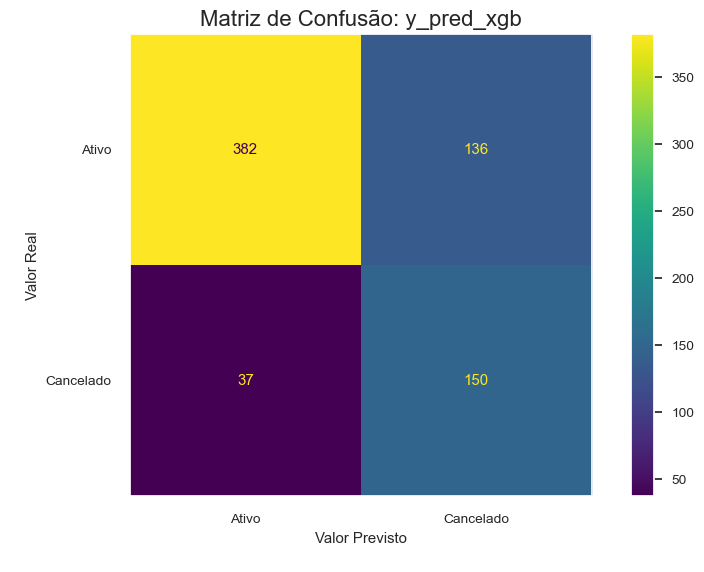

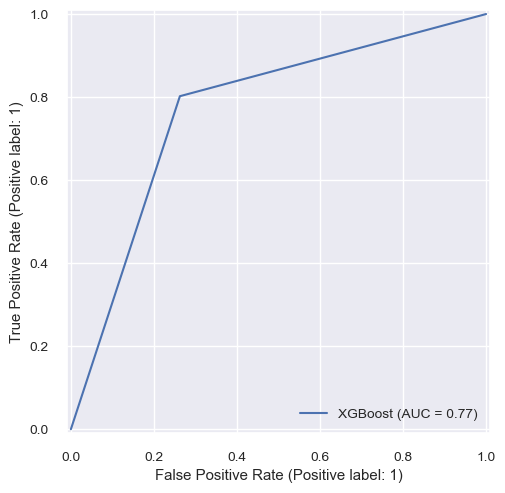

In [72]:
y_pred_xgb = model_grid_xgb.predict(X_teste[features_selecionadas])
y_proba_xgb = model_grid_xgb.predict_proba(X_teste[features_selecionadas])[:, 1]
print(f'Acurácia: {model_grid_xgb.score(X_teste[features_selecionadas], y_teste):.3f}')
print(f'AUC-ROC: {roc_auc_score(y_teste, y_proba_xgb):.3f}')
print(classification_report(y_teste, y_pred_xgb))
matriz_confusao('y_pred_xgb', y_teste, y_pred_xgb)
RocCurveDisplay.from_predictions(y_teste, y_pred_xgb, name = 'XGBoost');

# 

# Comparação entre modelos

In [75]:
comparacao_df = pd.DataFrame(index=['Acurácia', 'Precisão', 'Recall', 'F1-Score', 'AUC-ROC'])
modelos = {'Dummy' : modelo_dummy, 'RandomForestClassifier' : model_grid, 'XGBoost' : model_grid_xgb}

for nome, modelo in modelos.items():

    y_pred = modelo.predict(X_teste[features_selecionadas])
    y_proba = modelo.predict_proba(X_teste[features_selecionadas])[:, 1]

    metrics = {
        'Acurácia': accuracy_score(y_teste, y_pred),
        'Precisão': precision_score(y_teste, y_pred),
        'Recall': recall_score(y_teste, y_pred),
        'F1-Score': f1_score(y_teste, y_pred),
        'AUC-ROC': roc_auc_score(y_teste, y_proba)
    }

    comparacao_df[nome] = list(metrics.values())

comparacao_df

,Dummy,RandomForestClassifier,XGBoost
Acurácia,0.626950,0.747518,0.754610
Precisão,0.300000,0.514950,0.524476
Recall,0.304813,0.828877,0.802139
F1-Score,0.302387,0.635246,0.634249
AUC-ROC,0.524028,0.855558,0.847067


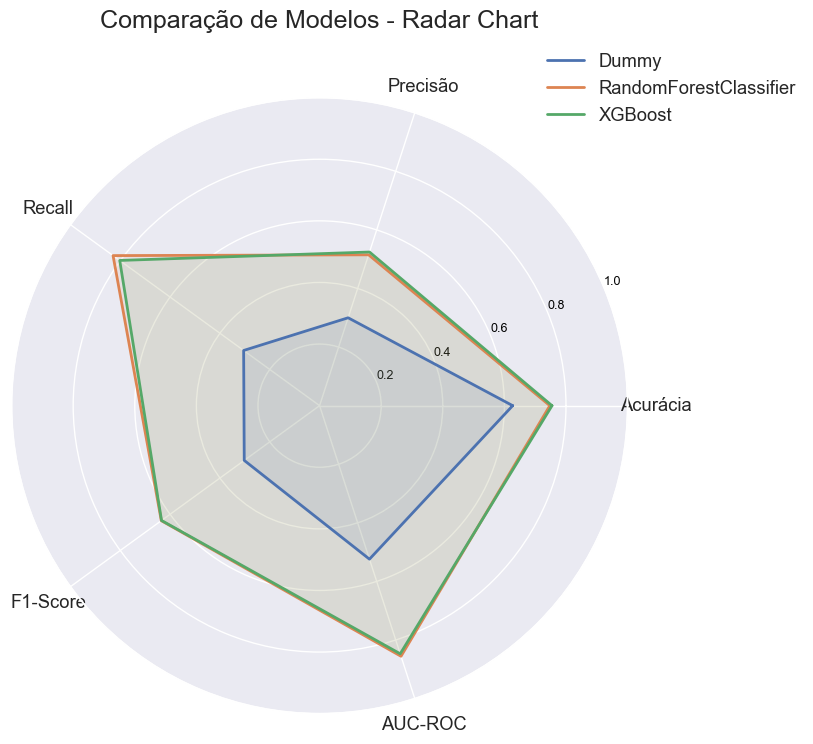

In [87]:
categories = list(comparacao_df.index)
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw = dict(polar = True))

for modelo in comparacao_df.columns:
    values = comparacao_df[modelo].values.flatten().tolist()
    values += values[:1]  
    ax.plot(angles, values, linewidth = 2, label = modelo)
    ax.fill(angles, values, alpha = 0.1)

plt.xticks(angles[:-1], categories)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], color = "black", size = 9)
plt.ylim(0, 1)
plt.title('Comparação de Modelos - Radar Chart', fontsize = 18, y = 1.1)
plt.legend(loc = 'upper right', bbox_to_anchor = (1.3, 1.1))
plt.show()

# 

# Salvando modelo escolhido: RandomForestClassifier	

In [88]:
try:
    with open('Modelo_Detecção_de_Churn.pkl', 'wb') as file:
        pickle.dump(model_grid.best_estimator_, file)
    print('Modelo salvo com Sucesso!')
except Exception as e:
    print(f'Erro :{str(e)} ao salvar o modelo')

Modelo salvo com Sucesso!


# 

# 📋  Interpretação e Conclusões 

### 🔍 Análise de Importância das Variáveis

<img src="Features_Importantes.jpg"/>
<img src="23_features.jpg"/>
<img src="Grafico_23_features.png"/>

Conforme demonstrado no segundo gráfico, embora seja observada uma leve redução na acurácia e precisão entre as 19 e 23 features mais importantes, a vigésima terceira feature apresenta o melhor desempenho em termos de Recall, com subsequente declínio beyond deste ponto. Considerando que o objetivo principal é a identificação de verdadeiros positivos, a decisão foi priorizar esta métrica, mantendo as 23 features evidenciadas no terceiro gráfico.

# ✅ Conclusão

Considerando que o objetivo principal consiste na identificação proativa de clientes com potencial de evasão (churn), optou-se por priorizar a métrica de Recall, que quantifica a capacidade do modelo em detectar verdadeiros positivos. O algoritmo `RandomForestClassifier` demonstrou o melhor desempenho, atingindo os seguintes resultados: `Acurácia: 74,75%`, `Precisão: 51,5%`, `Recall: 82,9%`, `F1-Score: 63,52%` e `AUC-ROC: 85,56%`. A divisão dos dados em conjuntos de treino, validação e teste (10% para teste final) revelou consistência de performance across todas as etapas, sugerindo robustez do modelo e baixa susceptibilidade a overfitting.

#### 🎯 Recomendações

`- Duração do Contrato:` Identificou-se que contratos mensais representam o principal fator de churn, enquanto contratos bienais correspondem ao segundo maior fator de retenção. A análise demonstra uma correlação inversa entre tempo de permanência e probabilidade de cancelamento. Como estratégia mitigatória, propõe-se: (1) implementar ações direcionadas a clientes com contratos de curta duração, e (2) otimizar o portfólio de benefícios para contratos de longo prazo, visando incrementar a taxa de conversão para modalidades estendidas.

`- Conta Mensal e Fibra Ótica`: A análise revelou que elevados valores de conta mensal e a contratação de fibra ótica constituem preditores significativos de churn. Identificou-se expressiva correlação positiva entre estas variáveis (r = 0,79)- observado no grafico abaixo-, sugerindo possível premium tarifário associado ao serviço de fibra ótica. Recomenda-se: (1) benchmark competitivo de preços, (2) análise de elasticidade-preço da demanda, e (3) desenvolvimento de pacotes promocionais vinculados à fidelização, visando simultaneamente reduzir o custo percebido e aumentar a retenção.

<img src="Custo_Fibra.jpg"/>

`🚀 Implementação do Sistema de Predição de Churn:` Implementar o algoritmo RandomForestClassifier em ambiente de produção para identificação proativa de clientes com elevada propensão à evasão, permitindo intervenções segmentadas e tempestivas. Estabelecer ciclo contínuo de monitoramento e reavaliação do modelo, incluindo: (1) tracking contínuo de performance (Recall, AUC-ROC), (2) recalibração periodica com dados atualizados, e (3) validação de impacto das ações de retenção baseadas nas previsões, (4) alinhar às melhores práticas de MLOps. "